In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
import mne
from mne.datasets import eegbci
from mne.io import read_raw_edf, concatenate_raws
import copy


SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

#  CONFIGURATION
SUBJECTS = [8]        # Testing on Subject 8
RUNS = [6, 10, 14]     # Task 4: Motor Imagery (Fists vs Feet)

# Preprocessing Constants
LOW_FREQ, HIGH_FREQ = 8.0, 30.0  # Mu & Beta bands (Motor Imagery)
TMIN, TMAX = 0.0, 4.0            # 4-second trials
RESAMPLE_RATE = 128              # Downsample to 128Hz

# Training Hyperparameters
BATCH_SIZE = 16
EPOCHS = 60
LEARNING_RATE = 0.001
N_FOLDS = 5            # 5-Fold Stratified Cross-Validation
PATIENCE = 15          # Early Stopping

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [11]:
#  DATA LOADING & PREPROCESSING
def load_subject_data(subject_id):
    """Loads, filters, and epochs data for a single subject."""
    try:
        # Load raw files
        fnames = eegbci.load_data(subject_id, RUNS, verbose=False)
        raws = [read_raw_edf(f, preload=True, stim_channel='auto', verbose=False) for f in fnames]
        raw = concatenate_raws(raws)

        # Standardize and set Montage
        eegbci.standardize(raw)
        raw.set_montage('standard_1005')

        # Keep only EEG channels
        raw.pick(['eeg'], exclude='bads')

        # Filter (8-30 Hz) - Critical for Motor Imagery
        raw.filter(LOW_FREQ, HIGH_FREQ, fir_design='firwin', skip_by_annotation='edge', verbose=False)

        # Event Mapping (T1=Fists, T2=Feet) -> (0, 1)
        event_map = {'T1': 0, 'T2': 1}
        events, _ = mne.events_from_annotations(raw, event_id=event_map, verbose=False)

        # Create Epochs
        epochs = mne.Epochs(raw, events, event_id=event_map, tmin=TMIN, tmax=TMAX,
                            baseline=None, preload=True, verbose=False)

        # Resample
        epochs.resample(RESAMPLE_RATE)

        return epochs.get_data(copy=False), epochs.events[:, -1]

    except Exception as e:
        print(f"Error loading Subject {subject_id}: {e}")
        return None, None

def build_dataset(subjects):
    """Combines data from listed subjects."""
    X_list, y_list = [], []
    for sub in subjects:
        X_sub, y_sub = load_subject_data(sub)
        if X_sub is not None:
            # Note: We do NOT scale here. Scaling happens inside the K-Fold loop.
            X_list.append(X_sub)
            y_list.append(y_sub)

    if not X_list:
        return np.array([]), np.array([])

    return np.concatenate(X_list, axis=0), np.concatenate(y_list, axis=0)

In [12]:
# --- 4. MODEL DEFINITIONS ---
class EEGNet(nn.Module):

    def __init__(self, nb_classes, Chans=64, Samples=128, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16):
        super(EEGNet, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, F1, (1, kernLength), padding=(0, kernLength // 2), bias=False),
            nn.BatchNorm2d(F1)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(F1, F1 * D, (Chans, 1), groups=F1, bias=False),
            nn.BatchNorm2d(F1 * D),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(dropoutRate)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(F1 * D, F2, (1, 16), padding=(0, 8), bias=False),
            nn.BatchNorm2d(F2),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(dropoutRate)
        )
        self.classifier = nn.Linear(self._get_flatten_size(Chans, Samples), nb_classes)

    def _get_flatten_size(self, Chans, Samples):
        with torch.no_grad():
            x = torch.zeros(1, 1, Chans, Samples)
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv3(x)
            return x.view(1, -1).size(1)

    def forward(self, x):
        x = x.unsqueeze(1) # Add channel dim
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

class ShallowConvNet(nn.Module):

    def __init__(self, nb_classes, Chans=64, Samples=128, dropoutRate=0.5):
        super(ShallowConvNet, self).__init__()

        self.conv_temporal = nn.Conv2d(1, 40, (1, 13), bias=False)
        self.conv_spatial = nn.Conv2d(40, 40, (Chans, 1), bias=False)
        self.bn1 = nn.BatchNorm2d(40)
        self.pool = nn.AvgPool2d((1, 35), stride=(1, 7))
        self.dropout = nn.Dropout(dropoutRate)
        self.classifier = nn.Linear(self._get_flatten_size(Chans, Samples), nb_classes)

    def _get_flatten_size(self, Chans, Samples):
        with torch.no_grad():
            x = torch.zeros(1, 1, Chans, Samples)
            x = self.conv_temporal(x)
            x = self.conv_spatial(x)
            x = self.pool(x)
            return x.view(1, -1).size(1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv_temporal(x)
        x = self.conv_spatial(x)
        x = self.bn1(x)
        x = torch.square(x) # Squaring (Power approximation)
        x = self.pool(x)
        x = torch.log(torch.clamp(x, min=1e-6)) # Log Transform
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [13]:
#  TRAINING LOOP (With Early Stopping & Correct Scaling)
def train_and_validate(model_class, X, y, chans, samples):
    history = {'train_loss': [], 'val_acc': [], 'all_preds': [], 'all_true': []}
    fold_accuracies = []

    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

    print(f"\n--- Training {model_class.__name__} ---")

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        # 1. Split Data
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # 2. SCALING (Inside loop to prevent leakage)
        scaler = mne.decoding.Scaler(scalings='mean')
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # 3. Create DataLoaders
        train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
        test_ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

        # 4. Initialize Model & Optimizer
        model = model_class(nb_classes=2, Chans=chans, Samples=samples).to(device)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        criterion = nn.CrossEntropyLoss()
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

        # 5. Train with Early Stopping
        best_acc = 0.0
        best_model_wts = copy.deepcopy(model.state_dict())
        patience_counter = 0
        epoch_losses = []

        for epoch in range(EPOCHS):
            model.train()
            batch_losses = []
            for b_X, b_y in train_loader:
                b_X, b_y = b_X.to(device), b_y.to(device)
                optimizer.zero_grad()
                loss = criterion(model(b_X), b_y)
                loss.backward()
                optimizer.step()
                batch_losses.append(loss.item())

            scheduler.step()
            epoch_losses.append(np.mean(batch_losses))

            # Validation
            model.eval()
            correct, total = 0, 0
            with torch.no_grad():
                for b_X, b_y in test_loader:
                    b_X, b_y = b_X.to(device), b_y.to(device)
                    outputs = model(b_X)
                    _, predicted = torch.max(outputs, 1)
                    total += b_y.size(0)
                    correct += (predicted == b_y).sum().item()

            val_acc = correct / total

            # Checkpoint
            if val_acc >= best_acc:
                best_acc = val_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= PATIENCE:
                break # Stop early

        # Load Best Model
        model.load_state_dict(best_model_wts)

        # Final Inference on Test Fold
        model.eval()
        preds, true_labels = [], []
        with torch.no_grad():
            for b_X, b_y in test_loader:
                b_X = b_X.to(device)
                outputs = model(b_X)
                preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                true_labels.extend(b_y.numpy())

        acc = accuracy_score(true_labels, preds)
        fold_accuracies.append(acc)
        history['train_loss'].append(epoch_losses)
        history['all_preds'].extend(preds)
        history['all_true'].extend(true_labels)

        print(f"Fold {fold+1}/{N_FOLDS}: Best Val Acc: {acc*100:.2f}%")

    return history, fold_accuracies

In [14]:
# --- 6. IMPROVED PLOTTING ---
def plot_results(hist_eeg, hist_shallow, acc_eeg, acc_shallow):
    plt.figure(figsize=(14, 10))

    # 1. Box Plot (Accuracy Distribution)
    plt.subplot(2, 2, 1)
    # Combine data for plotting
    data_to_plot = [acc_eeg, acc_shallow]
    plt.boxplot(data_to_plot, labels=['EEGNet', 'ShallowConvNet'], patch_artist=True)
    plt.title('Validation Accuracy Distribution (5 Folds)')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)

    # 2. Text Summary
    plt.subplot(2, 2, 2)
    plt.axis('off')
    summary_text = (
        f"Subject: {SUBJECTS[0]}\n"
        f"Trials: {len(hist_eeg['all_true'])}\n\n"
        f"EEGNet Mean Acc: {np.mean(acc_eeg)*100:.2f}%\n"
        f"EEGNet Std Dev:  {np.std(acc_eeg)*100:.2f}%\n\n"
        f"Shallow Mean Acc: {np.mean(acc_shallow)*100:.2f}%\n"
        f"Shallow Std Dev:  {np.std(acc_shallow)*100:.2f}%"
    )
    plt.text(0.1, 0.5, summary_text, fontsize=14, va='center')

    # 3. EEGNet Confusion Matrix
    plt.subplot(2, 2, 3)
    cm_eeg = confusion_matrix(hist_eeg['all_true'], hist_eeg['all_preds'])
    sns.heatmap(cm_eeg, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'EEGNet Confusion Matrix\n(Total Correct: {np.trace(cm_eeg)})')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.gca().set_xticklabels(['Fists', 'Feet'])
    plt.gca().set_yticklabels(['Fists', 'Feet'])

    # 4. ShallowConvNet Confusion Matrix
    plt.subplot(2, 2, 4)
    cm_shallow = confusion_matrix(hist_shallow['all_true'], hist_shallow['all_preds'])
    sns.heatmap(cm_shallow, annot=True, fmt='d', cmap='Greens', cbar=False)
    plt.title(f'ShallowConvNet Confusion Matrix\n(Total Correct: {np.trace(cm_shallow)})')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.gca().set_xticklabels(['Fists', 'Feet'])
    plt.gca().set_yticklabels(['Fists', 'Feet'])

    plt.tight_layout()
    plt.show()

Loading Subject 8...
Data Shape: (45, 64, 513) (Trials, Channels, Time)

--- Training EEGNet ---
Fold 1/5: Best Val Acc: 66.67%
Fold 2/5: Best Val Acc: 55.56%
Fold 3/5: Best Val Acc: 100.00%
Fold 4/5: Best Val Acc: 88.89%
Fold 5/5: Best Val Acc: 88.89%

--- Training ShallowConvNet ---
Fold 1/5: Best Val Acc: 88.89%
Fold 2/5: Best Val Acc: 88.89%
Fold 3/5: Best Val Acc: 88.89%
Fold 4/5: Best Val Acc: 88.89%
Fold 5/5: Best Val Acc: 77.78%

=== FINAL RESULTS (Subject 8) ===
EEGNet Avg Acc:      80.00% (+/- 16.33)
ShallowNet Avg Acc:  86.67% (+/- 4.44)


/var/folders/vm/bk5q5d2s5ys8tfz465b3_wxw0000gn/T/ipykernel_60485/4089268790.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=['EEGNet', 'ShallowConvNet'], patch_artist=True)


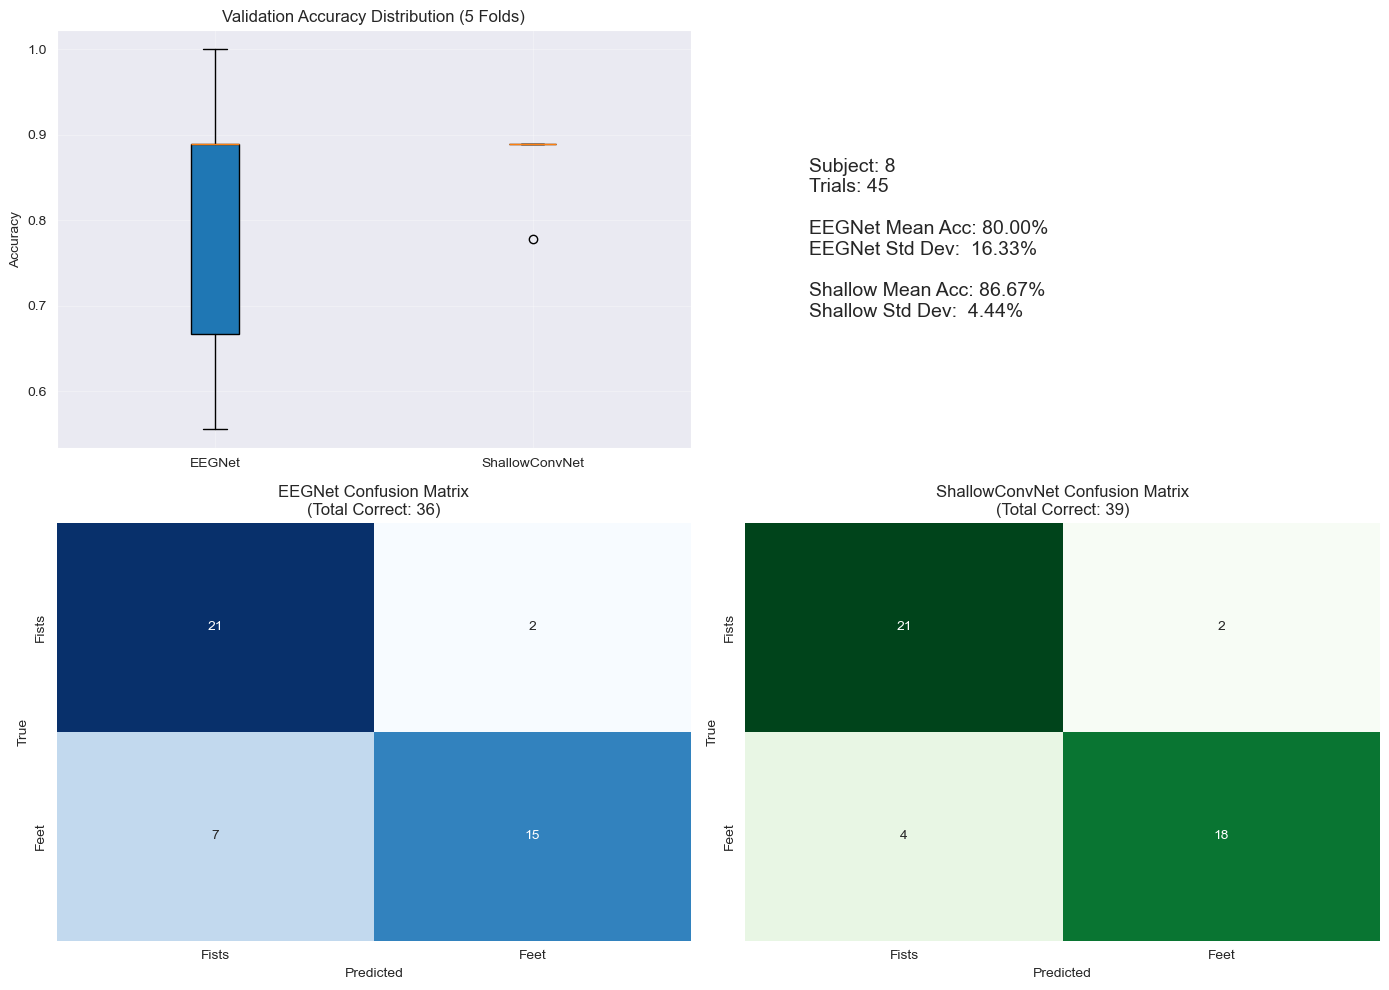

In [15]:
# --- 7. MAIN EXECUTION ---
if __name__ == "__main__":
    # 1. Load Data
    print(f"Loading Subject {SUBJECTS[0]}...")
    X, y = build_dataset(SUBJECTS)

    # Check if data loaded correctly
    if X.size == 0:
        print("Error: No data loaded. Check subject ID or internet connection.")
    else:
        # 2. Get Shapes
        n_chans, n_samples = X.shape[1], X.shape[2]
        print(f"Data Shape: {X.shape} (Trials, Channels, Time)")

        # 3. Train EEGNet
        hist_eeg, acc_eeg = train_and_validate(EEGNet, X, y, n_chans, n_samples)

        # 4. Train ShallowConvNet
        hist_shallow, acc_shallow = train_and_validate(ShallowConvNet, X, y, n_chans, n_samples)

        # 5. Final Report
        print(f"\n=== FINAL RESULTS (Subject {SUBJECTS[0]}) ===")
        print(f"EEGNet Avg Acc:      {np.mean(acc_eeg)*100:.2f}% (+/- {np.std(acc_eeg)*100:.2f})")
        print(f"ShallowNet Avg Acc:  {np.mean(acc_shallow)*100:.2f}% (+/- {np.std(acc_shallow)*100:.2f})")

        # 6. Plot
        plot_results(hist_eeg, hist_shallow, acc_eeg, acc_shallow)